# Hopf Bifurcation Study

In [1]:
from tqdm.notebook import tqdm
from os.path import isfile, splitext

import h5py
import numpy as np
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dolfin as dfn

from femvf import load, statefile as sf, meshutils
from femvf.models.transient import solid as smd, fluid as fmd
from femvf.signals.solid import make_sig_glottal_width_sharp
from blocktensor import h5utils as bh5utils
from vfsig import modal
from vfsig.misc import resample_over_uniform_period

import libhopf
import main_hopf
import libsignal
from lib_main_transient import case_config
import h5utils
from postprocutils import postprocess_case_to_signal

In [2]:
## Global vars
ZETA = 1e-4
R_SEP = 1.0
Y_GAP = 1e-2
# PSUBS = np.concatenate([np.arange(200, 300, 10), np.arange(300, 1000, 100)])*10
PSUBS = np.arange(550, 650, 10) * 10 
ECOV = 5e3 * 10
# EBODY = 15e3 * 10
EBODY = 5e3 * 10

# Load the transient model
INIT_STATE_TYPE = 'static'

OUT_DIR = f'out/zeta{ZETA:.2e}_rsep{R_SEP:.1f}_ygap{Y_GAP:.2e}_init{INIT_STATE_TYPE}_fixed_rsep'
FluidType = fmd.BernoulliMinimumSeparation
# OUT_DIR = f'out/zeta{ZETA:.2e}_rsep{R_SEP:.1f}_ygap{Y_GAP:.2e}_init{INIT_STATE_TYPE}_variable_rsep'
# FluidType = fmd.Bernoulli

MESH_NAME = 'BC-dcov5.00e-02-cl1.00'
mesh_path = f'mesh/{MESH_NAME}.xml'
model_tran = load.load_transient_fsi_model(
    mesh_path, None, 
    SolidType=smd.KelvinVoigt, 
    FluidType=FluidType, 
    coupling='explicit'
)

# load the Hopf models
res, dres = main_hopf.setup_models(mesh_path)
_region_to_dofs = meshutils.process_celllabel_to_dofs_from_forms(
    res.solid.forms, res.solid.forms['fspace.scalar'])
_props = main_hopf.set_props(res.props.copy(), _region_to_dofs, res)
res.set_props(_props)
dres.set_props(_props)

res_hopf = libhopf.HopfModel(res, dres)

## Post-process nonlinear oscillations (transient simulations)

In [3]:
## Initialize functions to extract glottal width from saved simulations

# Number of points per period to use in processing
N_PER_PERIOD = 100
proc_gw_tran = make_sig_glottal_width_sharp(model_tran)
proc_gw_hopf = libsignal.make_glottal_width(res_hopf, num_points=N_PER_PERIOD)
def time(f):
    return np.array(f.get_times())

In [4]:
## Post processing transient simulations
postprocess_fname = f'{OUT_DIR}/data.h5'
signal_to_proc = {
    'glottal_width': proc_gw_tran,
    'time': time}
files = [f'{OUT_DIR}/{case_config(MESH_NAME, psub, ECOV, EBODY)}.h5' for psub in PSUBS]

case_to_signal = postprocess_case_to_signal(postprocess_fname, files, model_tran, signal_to_proc)

# with h5py.File(postprocess_fname, mode='r') as f:
#     case_to_signal = h5utils.h5_to_dict(f, {})

100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 78.93it/s]


In [5]:
## Resample the transient simulations so that they a fixed number of points per period
cases = list(set([key.split('/')[0] for key in case_to_signal.keys()]))

NOFFSET = 3000
NPERIOD = 5

case_to_period = {
    case:
    int(round(
        modal.estimate_fundamental_mode(
            case_to_signal[f'{case}/glottal_width'][NOFFSET:])[0]**-1
    ))
    for case in cases}

case_to_rsignal = {}
for case in cases:
    xp = np.arange(case_to_signal[f'{case}/glottal_width'].size-NOFFSET)
    fp = case_to_signal[f'{case}/glottal_width'][NOFFSET:]
    
    samples_per_period = case_to_period[f'{case}']
    num_period = int(fp.size/samples_per_period)
    
    x = np.linspace(0, num_period, num_period*N_PER_PERIOD + 1) * samples_per_period
    
    case_to_rsignal[f'{case}/glottal_width'] = np.interp(x, xp, fp)

case_to_rsignal_update = {
    f'{case}/time': 
    np.arange(case_to_rsignal[f'{case}/glottal_width'].size)/N_PER_PERIOD
    for case in cases}

case_to_rsignal.update(case_to_rsignal_update)

In [6]:
## Post processing Hopf simulation (load the Hopf bifurcation state)
hopf_sim_fpath = f"out/hopf_state.h5"

with h5py.File(hopf_sim_fpath, mode='r') as f:
    hopf_state = bh5utils.read_block_vector_from_group(f)

# Decompose the Hopf state vector to common components
xfp_hopf = hopf_state[:4]
mode_hopf_real, mode_hopf_imag = hopf_state[4:8], hopf_state[8:12]
# mode_hopf = mode_hopf_real + 1j*mode_hopf_imag
omega_hopf = hopf_state['omega'][0]
psub_hopf = hopf_state['psub'][0]

unit_mode_real, unit_mode_imag = libhopf.normalize_eigenvector_amplitude(
    mode_hopf_real, mode_hopf_imag)

## Plots

### Nonlinear oscillations

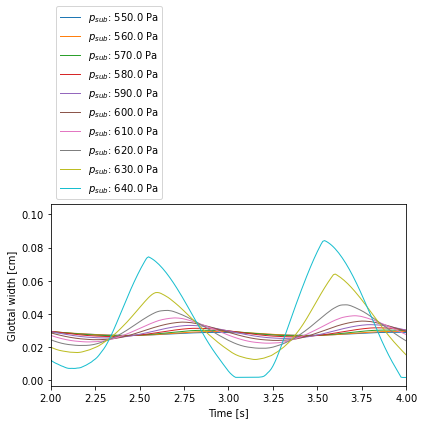

In [25]:
## Plot transient simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for psub in PSUBS:
    case = case_config(MESH_NAME, psub, ECOV, EBODY)
    t = case_to_rsignal[f'{case}/time']
    gw = case_to_rsignal[f'{case}/glottal_width']
    
    ax.plot(t, gw, label=f"$p_{{sub}}$: {psub/10:.1f} Pa", lw=1.0)
    
ax.set_xlim(2, 4)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Glottal width [cm]")
ax.legend(loc='lower left', bbox_to_anchor=(0, 1))

fig.tight_layout()
fig.savefig(f'fig/transient_glottal_width.png')

### Small amplitude oscillations

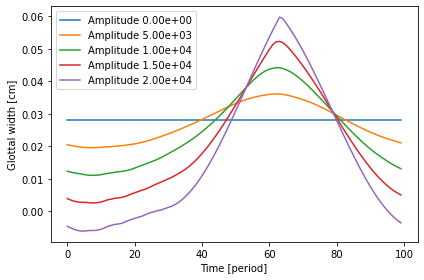

In [26]:
## Plot Hopf simulations
fig, ax = plt.subplots(1, 1)

for ampl in np.linspace(0, 20000.0, 5):
    gw = proc_gw_hopf(
        hopf_state.to_ndarray(),
        np.array([ampl, 0.0]))
    ax.plot(gw, label=f"Amplitude {ampl:.2e}")
    
ax.set_xlabel(f"Time [period]")
ax.set_ylabel("Glottal width [cm]")
ax.legend()

fig.tight_layout()
fig.savefig("fig/onset_gw_vs_amplitude.png", dpi=250)

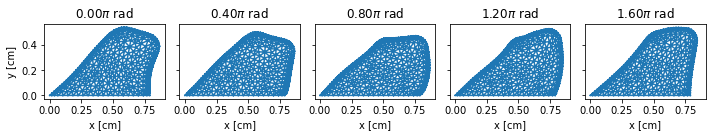

In [29]:
## Plot the onset mode shape
import dolfin as dfn
XREF = res.solid.XREF.vector()

NPHASE = 5
phases = 2*np.pi*np.linspace(0, 1, NPHASE+1)[:-1]

VERT_TO_VECDOF = dfn.vertex_to_dof_map(res.solid.forms['fspace.vector'])
CELLS = res.solid.forms['mesh.mesh'].cells()

fig, axs = plt.subplots(1, NPHASE, sharey=True, sharex=True, figsize=(10, 5))
for ax, phase in zip(axs, phases):
    ampl = 5e4*np.exp(1j*phase)
    mode_hopf_dof_order = (
        XREF[:] + hopf_state['u'] 
        + np.real(
            ampl * (
                hopf_state['u_mode_real'] 
                + 1j*hopf_state['u_mode_imag'])
            )
        )
    
    mode_hopf_vert_order = mode_hopf_dof_order[VERT_TO_VECDOF].reshape(-1, 2)
    # print(mode_hopf_vert_order.shape)
    ax.triplot(*mode_hopf_vert_order.T, triangles=CELLS)
    ax.set_title(f"${phase/np.pi:.2f}\pi$ rad")
    
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel("x [cm]")
axs[0].set_ylabel("y [cm]")
    
fig.tight_layout()
fig.savefig(f'fig/hopf_mode_shape.png', dpi=200)

### Compare nonlinear and small-amplitude oscillations

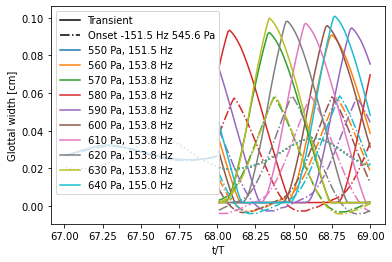

In [28]:
## Plot Transient vs Hopf simulations
SCALE = np.array([1e4, 1])

def sqr_err(sc_ampl_phase, gw_ref):
    """
    Return the squared error between onset and reference glottal widths
    """
    ampl_phase = sc_ampl_phase*SCALE
    gw_hopf = proc_gw_hopf(
        hopf_state.to_ndarray(), 
        ampl_phase)
    
    err = (gw_hopf-gw_ref)**2
    return jnp.sum(err)

from scipy import optimize

fig, ax = plt.subplots(1, 1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
psubs = np.array([600, 700, 800, 900])*10
psubs = PSUBS
# psubs = PSUBS[0::2]

cases = [case_config(MESH_NAME, psub, ECOV, EBODY) for psub in psubs]
for ii, (psub, color, case) in enumerate(zip(psubs, colors, cases)):
    # For each case, load the transient simulation glottal width 
    t = case_to_rsignal[f'{case}/time'][-N_PER_PERIOD:]
    gw_tran = case_to_rsignal[f'{case}/glottal_width'][-N_PER_PERIOD:]
    
    # Calculate an optimal phase and amplitude for the onset glottal width
    # that minimizes the difference from the transient glottal width
    ampl_phase0 = np.array([5e3, 0.0])
    opt_res = optimize.minimize(sqr_err, ampl_phase0/SCALE, args=(gw_tran,), jac=jax.grad(sqr_err, 0), method='BFGS')
    ampl_phase = opt_res['x'] * SCALE
    # print(opt_res)
    
    # Compute the onset glottal width with the optimal phase and amplitude
    gw_hopf0 = proc_gw_hopf(
        hopf_state.to_ndarray(),
        ampl_phase0)
    
    gw_hopf = proc_gw_hopf(
        hopf_state.to_ndarray(),
        ampl_phase)
    
    ax.plot(t, gw_tran, color=color, ls='-')
    ax.plot(t, gw_hopf, color=color, ls='-.')
    ax.plot(t, gw_hopf0, color=color, ls=':')
    
ax.set_xlabel("t/T")
ax.set_ylabel("Glottal width [cm]")

from matplotlib.lines import Line2D

f0s = []
for case in cases:
    _t = case_to_signal[f'{case}/time']
    dt = _t[1]-_t[0]
    f0s.append((case_to_period[f'{case}'] * dt)**-1)

# Make a legend describing the relationship 
# ls -> model type and psub -> color
_model_type_ls = ['-', '-.']
_model_type_lines = [Line2D([0], [0], color='k', ls=ls) for ls in _model_type_ls] 
_model_type_labels = ["Transient", f"Onset {omega_hopf/2/np.pi:.1f} Hz {psub_hopf/10:.1f} Pa"]

_psub_colors = colors[:len(psubs)]
_psub_lines = [Line2D([0], [0], color=color) for color in _psub_colors]
_psub_labels = [f"{psub/10:.0f} Pa, {f0:.1f} Hz" for psub, f0 in zip(psubs, f0s)]
ax.legend(
    _model_type_lines+_psub_lines,
    _model_type_labels+_psub_labels)

fig.savefig('fig/transient_vs_onset_gw.png', dpi=200)

### Optimization results

In [3]:
# Load mesh and DOF map information for plotting data on the mesh
TRI = res.solid.forms['mesh.mesh'].coordinates()
X, Y = TRI[:, 0], TRI[:, 1]
CELLS = res.solid.forms['mesh.mesh'].cells()

# These indices select DOFs from a scalar function in vertex-order
IDX_VERT = dfn.vertex_to_dof_map(res.solid.forms['fspace.scalar'])

In [66]:
# Load optimization history
with h5py.File('out/opt_hist.h5', mode='r') as f:
    objs = f['objective'][:]
    grads = [bh5utils.read_block_vector_from_group(f['grad'], nn) for nn in range(len(objs))]
    params = [bh5utils.read_block_vector_from_group(f['parameters'], nn) for nn in range(len(objs))]
    
its = np.arange(len(objs))

#### Plot a summary of optimization results

In [67]:
# Indicate a specific iteration to plot parameters for
N = -4
grad = grads[N]
param = params[N]

In [68]:
print(param.bshape)
print(res.props.bshape)

((355, 1, 355, 355, 2, 1, 1, 1, 1, 1, 1, 1, 1),)
((355, 1, 355, 355, 2, 1, 1, 1, 1, 1, 1),)


In [69]:
# First you have to compute the spectrum; if you save more data in the optimization history file
# you might be able to avoid some of these computations

# Set the dynamical system residual properties + subglottal pressure
res.set_props(param[:-2])
res.control['psub'].set(objs[N])
res.set_control(res.control)

x_fp0 = res.state.copy()
x_fp0.set(0.0)
x_fp, info = libhopf.solve_fixed_point(res, x_fp0)
print(info)
omegas, *_eigvecs = libhopf.solve_linear_stability(res, x_fp)

print(omegas)

{'status': 0, 'message': 'solver converged', 'abs_errs': array([2.20436454e+04, 6.14765214e+03, 7.73227256e+02, 9.38606073e+01,
       2.15472768e+00, 1.85772721e-02, 1.20448637e-06]), 'rel_errs': array([1.00000000e+00, 2.78885458e-01, 3.50771046e-02, 4.25794398e-03,
       9.77482462e-05, 8.42749542e-07, 5.46409793e-11])}
[-1.25483419e+01 +442.9784849j  -1.25483419e+01 -442.9784849j
  3.41436606e-03 +951.73529801j  3.41436606e-03 -951.73529801j
 -1.05366131e+02 +966.7455854j  -1.05366131e+02 -966.7455854j
 -1.46281953e+02+1323.62963591j -1.46281953e+02-1323.62963591j
 -1.79837593e+02+1637.9983552j  -1.79837593e+02-1637.9983552j
 -1.83324707e+02+1763.98993607j -1.83324707e+02-1763.98993607j
 -3.25989497e+02+2011.46174759j -3.25989497e+02-2011.46174759j]


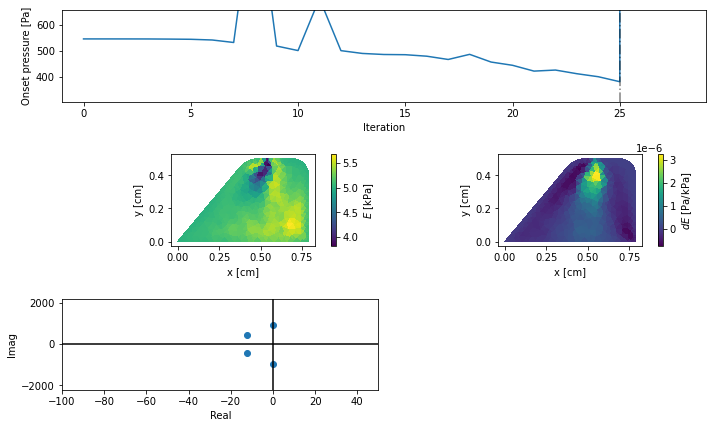

In [71]:
objs_pa = objs/10

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot the objective function history
ax_obj = fig.add_subplot(gs[0, :])
ax = ax_obj

ax.plot(objs_pa)
ax.axvline([its[N]], color='k', ls='-.', alpha=0.5)

ax.set_xlabel("Iteration")
ax.set_ylabel("Onset pressure [Pa]")
ax.set_xlim(its[[0, -1]] + np.array([-1, 1]))
ax.set_ylim([0.8*objs_pa.min(), 1.2*objs_pa[0]])

# Plot the current parameter guess
ax_mod = fig.add_subplot(gs[1, 0])
ax = ax_mod

mappable = ax.tripcolor(X, Y, CELLS, param['emod'][IDX_VERT]/10/1e3)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

cbar = fig.colorbar(mappable, ax=ax)
cbar.ax.set_ylabel("$E$ [kPa]")
ax.set_aspect(1)

# Plot the current gradient
ax_grad = fig.add_subplot(gs[1, 1])
ax = ax_grad

mappable = ax.tripcolor(X, Y, CELLS, grad['emod'][IDX_VERT]/10/1e3)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

cbar = fig.colorbar(mappable, ax=ax)
cbar.ax.set_ylabel("$dE$ [Pa/kPa]")
ax.set_aspect(1)

# Plot the spectrum
ax_spec = fig.add_subplot(gs[2, 0])
ax = ax_spec
ax.scatter(omegas.real, omegas.imag)
ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.set_xlabel("Real")
ax.set_ylabel("Imag")
ax.set_xlim(-100, 50)

fig.tight_layout()